# ALEX17 Diurnal Cycles Benchmark: A Large Domain In Complex Terrain
## Introduction
This is the model evaluation notebook of the ALEX17 benchmark. A guide for participants can be found [here](https://thewindvaneblog.com/alex17-diurnal-cycles-benchmark-a-large-domain-in-complex-terrain-b5029e94485).

## Load libraries

In [15]:
%matplotlib inline
# Python packages
import os, datetime, sys
import numpy as np
import pandas as pd
import matplotlib as plt
from pathlib import Path
import warnings
# local functions
from lib.alex17_functions2 import *
from lib.alex17_plots import *

#from lib.alex17_functions import *  
from IPython.display import Markdown, display
#import ipywidgets as widgets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [17]:
# Set the csv filename with simulation's id and descriptions.
sim_list_file = 'alex17_sims'

# read table with models and simulation's description
sims = pd.read_csv(Path('./outputs')/(sim_list_file+'.csv'), comment='#')

## Input Data
### Elevation Map and Instrument Layout

In [18]:
# set paths of output files and input observations
observations_path   = Path('./observations')
output_path_figures = Path('./output_figures') / sim_list_file

# make sure directories exist. Created them otherwise
ensure_dir(output_path_figures) if saveFigures else ''
ensure_dir(observations_path) if saveTables else ''

In [19]:
# bools to choose whether save pngs of tables and figures
saveFigures = False
saveTables  = True
# set the desired dip for image quality (if saveFigures is True)
dpi_fig = 100

# Read file of mast names and position
masts = pd.read_csv(Path("./inputs/masts.csv"))
masts = masts.drop(masts[masts['Name']=='WLS70'].index)

# Read Z-transect points' location
Ztransect = pd.read_csv('./inputs/Ztransect.csv') # read {x,y,x} coordinates of Z-transect

# digital elevation map file
tif_topofile = Path('./inputs/DTM_Alaiz_2m.tif')
# plot overall site characteristics
f, a = plot_topography(tif_topofile, Ztransect, masts)
saveFigureFunction(saveFigures, f, output_path_figures / ('overview.png'), dpi_fig)

NameError: name 'rio' is not defined

### Mesoscale Input Data
Mesoscale simulations have been produced adopting most of the WRF settings that were used in the production run of the New European Wind Atlas (NEWA). Three one-way nested domains of 27, 9 and 3 km resolution are configured centred at the wind farm centroid. The vertical grid has 61 terrain-following (sigma) levels, with 10 levels covering the first 200 meters, more specifically at: 6, 22, 40, 56, 73, 90, 113, 140, 179 and 205 meters. High resolution topography (SRTM 90m) and updated land use categories (Corine Land Cover 2018), together with the Noah land-surface model are used to define the boundary conditions at the surface. The physical parameterizations are: Mellor–Yamada–Nakanishi Niino 2.5-level planetary boundary-layer scheme (MYNN), WRF Single-Moment 5-class microphysics scheme, the Rapid Radiative Transfer Model for GCMs shortwave and longwave radiation schemes and the Kain-Fritsch cumulus scheme in the outermost domains 1 and 2. The simulation is driven by input data from ERA-5 in blocks of 5 days with additional spin-up time of 24 hours.   

From the 3-km domain we extract output data that will be used as reference in validation plots. This constitute the baseline simulation (*alex17_00a*) that we try to improve with microscale modeling. 

## Validation Data
Three sets of measurements will be used for validation of the submitted results. The meteorological mast measurements are available for the modelers to check and calibrate their results, whereas the lidar measurements will be used for validation after submission (blind test). 
1. Vertical profiles at *mast* positions.
2. Wind vector at 125m a.g.l. along the *Z-transect*.
3. Vertical RHI plane across the valley along the *B* segment of the *Z-transect*. The Plane connects WS3 [617846.796; 4732496.246] km and WS5 [617305.590; 4729848.751] km.

In [20]:
# Load mast data contained in the observations netcdf file
masts_obs = read_obs(Path('./observations/masts_obs.nc'))

# Z-Transect data
#f_Ztransect = './observations/alex17_Ztransect.nc'


## Simulation Data
We load the simulations defined in *sims* table. Three sets of output data are collected from each simulation: 

1. *simID_masts.nc*: Vertical profiles extending 1km from the surface at the met mast locations (*inputs/masts.csv* coordinates);
2. *simID_Ztransect.nc*: Vertical planes along the Z-transect extending 1 km in the vertical (*inputs/Ztransect.csv* coordinates);
3. *simID_box.nc*: Horizontal planes at 125 m and 40 m a.g.l., with horizontal resolution of 100 m, within the “box” [612–622; 4726–4736] km.

Output data is provided based on 10-min averages.

In [21]:
# Load dataset at masts positions from simulations files listed in the alex17_sims.csv
masts_sim = {x:read_sim(Path('./outputs/' + x +'_masts.nc')) for x in sims['ID'].values }


## Compute Quantities of Interest and Metrics

In [8]:
# turbulence intensity
#ti = masts_obs.wind_speed_std / masts_obs.wind_speed
#masts_obs = masts_obs.assign(turbulence_intensity = ti)
#for i_sim in range(0,n_sim):
#    ti = (((2./3.)*masts_sim[i_sim].specific_turbulent_kinetic_energy)**0.5)/masts_sim[i_sim].wind_speed
#    masts_sim[i_sim] = masts_sim[i_sim].assign(turbulence_intensity = ti)

# wind shear 
#alpha = np.log(masts_obs.wind_speed.sel(height = 80)/masts_obs.wind_speed.sel(height = 40))/np.log(80./40.)
#masts_obs =  masts_obs.assign(wind_shear = alpha)
#for i_sim in range(0,n_sim):
#    alpha = np.log(masts_sim[i_sim].wind_speed.interp(height= 80)/masts_sim[i_sim].wind_speed.interp(height= 40))/np.log(80./40.)
#    masts_sim[i_sim] = masts_sim[i_sim].assign(wind_shear = alpha)

# stability
#zL = masts_obs.height / masts_obs.obukhov_length
#masts_obs = masts_obs.assign(stability = zL)                            

# Results
## Vertical profiles

In [22]:
# set events of atmospheric stability and color to plot them
events = {'all'        :[datetime.datetime(2018,9,30,0,0,0),  datetime.datetime(2018,10,4,0,0,0),  'white'      ],
          'neutral'    :[datetime.datetime(2018,10,1,18,0,0), datetime.datetime(2018,10,1,20,0,0), 'silver'     ],
          'stable'     :[datetime.datetime(2018,10,2,3,0,0),  datetime.datetime(2018,10,2,5,0,0),  'lightblue'  ],
          'unstable'   :[datetime.datetime(2018,10,2,12,0,0), datetime.datetime(2018,10,2,14,0,0), 'salmon'     ],
          'very stable':[datetime.datetime(2018,10,3,4,0,0) , datetime.datetime(2018,10,3,6,0,0),  'deepskyblue']}


--plotting: wind_speed ---------- cases: all
--plotting: wind_direction ---------- cases: all
--plotting: turbulence_intensity ---------- cases: all


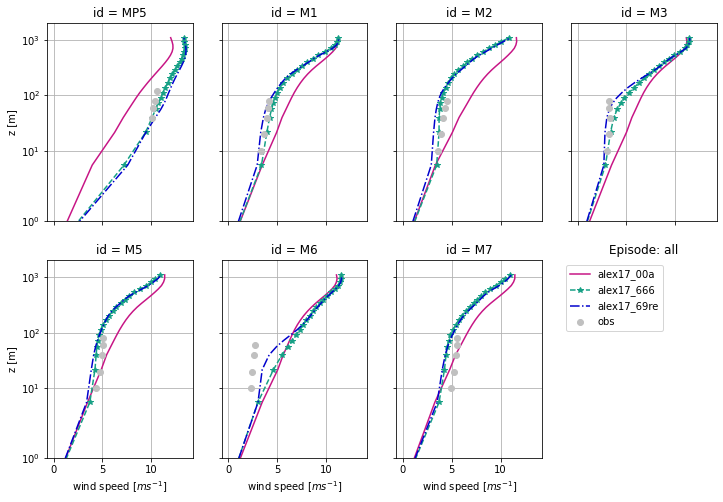

C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0, flags=flags)


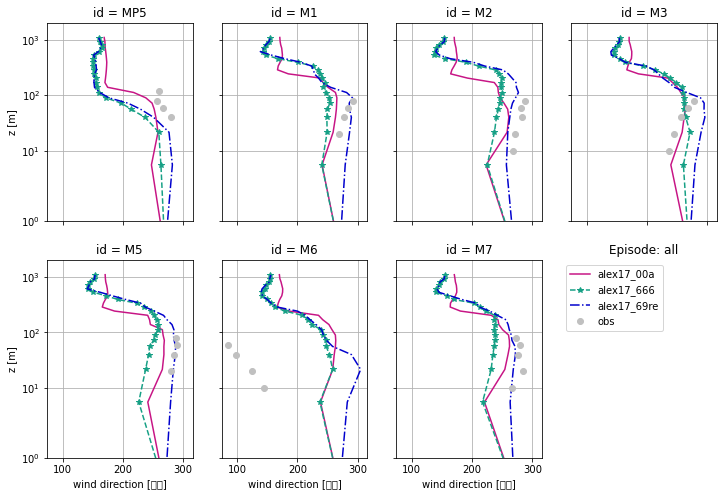

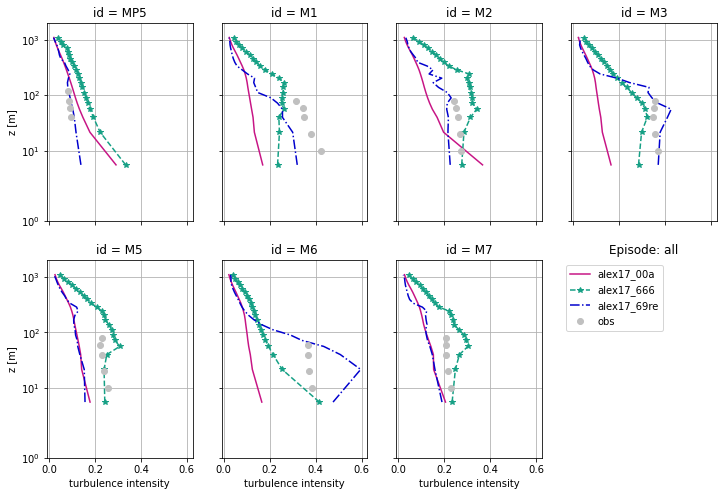

In [23]:
# List the mast's id you wish to plot
masts2plot = ['MP5', 'M1', 'M2','M3','M5', 'M6', 'M7']

#-------------------- Vertical profiles-------------------------------
# select the events you want to plot
events2plot = ['all','neutral','stable','unstable','very stable']
events2plot = ['all']

# list the variables and their labels
vars2plot    = [
               ['wind_speed',           r'wind speed [$m s^{-1}$]'],
               ['wind_direction',        r'wind direction [ยบ]'],
               ['turbulence_intensity',  r'turbulence intensity'],
               # ['friction_velocity',     r'$u^*$'],
               # ['heat_flux',             r'heat flux [$m K s^{-1}$]'],
               ]

for ev in events2plot:
    for ivar in vars2plot:
        print("--plotting: "+ivar[0]+' ---------- cases: ' +ev)
        f, ax = masts_sims_vs_obs_profiles_plot(events[ev], ivar, masts_obs, masts_sim, masts2plot)
        ax[-1][-1].set_title('Episode: ' + ev )
        saveFigureFunction(saveFigures, f, output_path_figures / ('vertical_profiles_'+ivar[0]+'_'+ev), dpi_fig)

## time series

C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0, flags=flags)


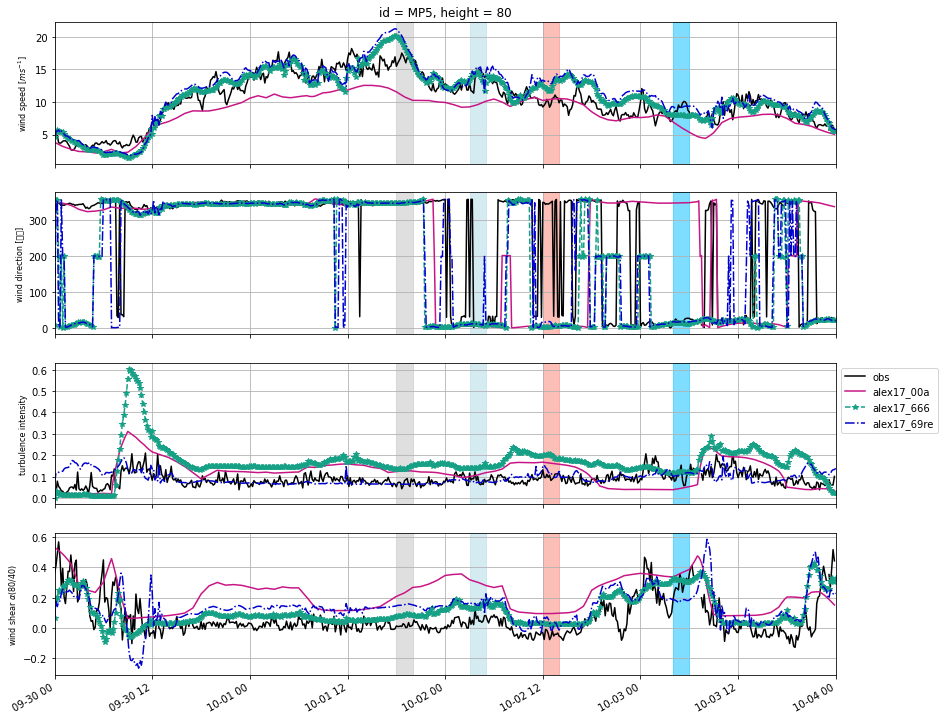

In [24]:
# set the height to plot the time series
h = 80

# List the mast's id you wish to plot
masts2plot = ['MP5', 'M1', 'M2','M3','M5', 'M6', 'M7']
masts2plot = ['MP5']

# set the variables to plot
vars2plot_ts = [
               ['wind_speed',              r'wind speed [$m s^{-1}$]'],
               ['wind_direction',          r'wind direction [ยบ]'],
               ['turbulence_intensity',    r'turbulence intensity'],
               ['wind_shear', r'wind shear $\alpha(80/40)$'],
               # ['stability',  r'stability $z/L$ ($z$=10m)']
               ]

# Set x-limits of the time series plot
datefrom, dateto = datetime.datetime(2018,9,30,0,0,0), datetime.datetime(2018,10,4,0,0,0)

for mast in masts2plot:
    f, ax = mast_sims_vs_obs_timeseries_plot(mast, h, vars2plot_ts, masts_obs, masts_sim, datefrom, dateto, events)
    saveFigureFunction(saveFigures, f, output_path_figures / ('time_'+mast), dpi_fig)



## Observation time series comparison

C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3618 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\12828\Anaconda3\envs\envWRF37\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0, flags=flags)


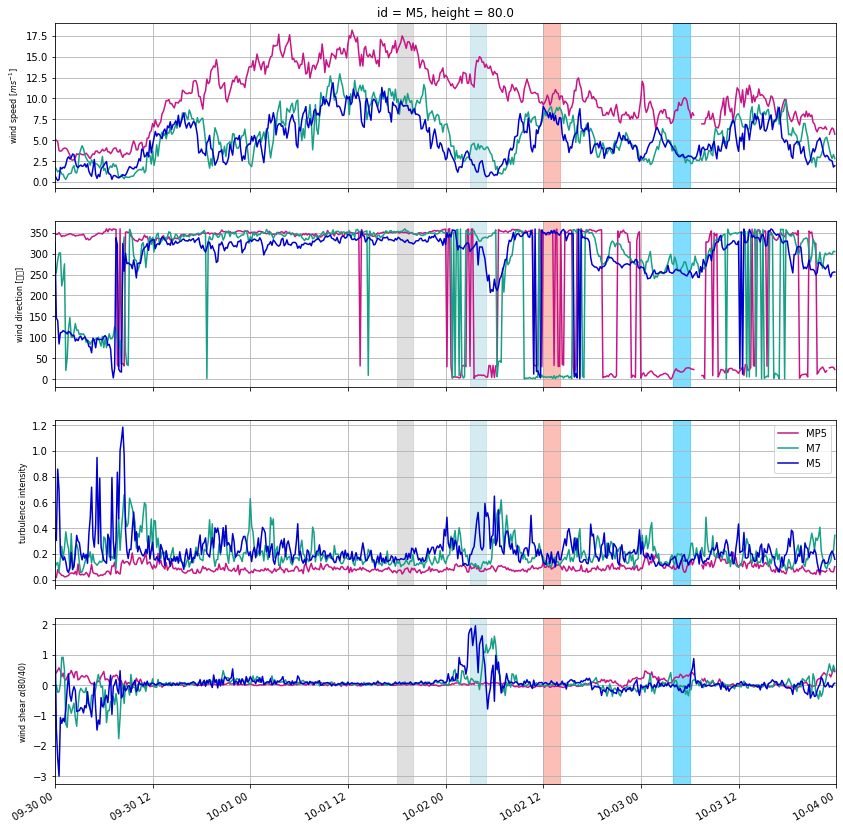

In [25]:
# set the height to plot the time series
h = 80.
# List the mast's id you wish to plot
mast = ['MP5','M7', 'M5']

f, ax = compare_masts_timeseries_plot(mast, h, vars2plot_ts, masts_obs, datefrom, dateto, events)
saveFigureFunction(saveFigures, f, output_path_figures / ('mast_compare_'+mast[0]+'-'+mast[1]), dpi_fig)


### Quantities of interest

In [26]:
masts_obs_quois = events_qois_vs_masts_table(events,masts_obs,h)
masts_obs_quois[mast]

NameError: name 'events_qois_vs_masts_table' is not defined